In [1]:
from sympy import *
import ternary
import numpy as np
from ternary.helpers import project_point
import matplotlib.pyplot as plt

init_printing()

Author's note: This notebook was co-authored by [Shikhara Bhat](https://thepandalorian.github.io/) and [Shivam Chitnis](https://scholar.google.com/citations?user=DZT4XFkAAAAJ&hl=en) in around 2021-2022.

## Hawk-Dove Game

In this model there is a population of Hawks ($H$) and a population of Doves ($D$). We assume that Hawks and Doves compete for food in pairwise interactions. When interacting, Hawks "fight to death" and Doves "retreat when attacked". When a bird gets the food its _Darwinian fitness_ (say number of children) increases by $V$. When a fight occurs, the injured opponent experiences a reduced fitness of $C$. 

### Payoffs

Therefore, when a Hawk meets a Hawk, we get the expected **payoff** i.e. **expected increase in fitness** to be 

$$E(H,H) = \dfrac{1}{2}(V-C)$$

This is because we assume that half the time the Hawk will win and half the time it will lose. When at Hawk meets a Dove, it gets the entire meal, i.e.

$$E(H,D) = V$$

When a Dove meets a Hawk it will get nothing since it retreats immediately. Therefore,

$$E(D,H) = 0$$

Finally, when a Dove meets a Dove, both can sit peacefully and enjoy their meal implying

$$E(D,D) = \dfrac{V}{2}$$

This information can be written as a matrix $M$ that will have useful properties. 


### Payoff Matrix
For a two-player, two-strategy game like the one we are discussing we write: 
 
$$M = \bigg[\begin{matrix} E(A,A)&E(A,B)\\ E(B,A)&E(B,B) \end{matrix}\bigg]$$

where $E(A,B)$ is the expected payoff for a player playing strategy $A$ against an opponent playing $B$.

#### Payoff Matrix for the Hawk-Dove Game

$$M = \bigg[\begin{matrix} (V-C)/2&V \\ 0&V/2 \end{matrix}\bigg]$$

In [2]:
def M(V,C):
    M = np.array([[(V-C)/2,V],[0,V/2]])
    return M

### Net Payoff

Now that we have a compact description of the model in the form of the matrix, we would like to get a sense of what happens when there are multiple interactions going on between birds in the wild. If the interactions happen completely at random, the frequency of $H$ individuals is $p_H$ and the frequency of $D$ individuals is $1-p_H$, then the expected fitness for a Hawk can be written as:

$$W(H) = W_0 + p_HE(H,H) + (1-p_H)E(H,D)$$

Similary, the fitness for a Dove can be written as:

$$W(D) = W_0 + (1-p_H)E(D,D) + p_HE(D,H)$$

where $W_0$ was the fitness of all the birds before the contests began.

In [3]:
def W(M,pH,W0=5):
    W = W0+np.matmul(M,np.array([pH,1-pH]).T)
    return W

### The Notion of Equilibrium

This is great. We now have a sense of the mean fitness of the animals in the two populations. It is intuitive (but we will make it precise) that when the fitness of the two populations is equal, their population sizes will not change.

On equating $W(H)$ and $W(D)$, we can derive

$$p_H = V/C$$

This is a nice result that tells us that if $V/C>0.5$ then there will be more Hawks than Doves and if $V/C<0.5$ there will be more Doves than Hawks. When $V/C>1$, it is possible to show from the following equations that $p_H = 1$.

### How can we make this notion of equilibrium more precise?

Since we want to understand how strategies _change over time_ we can make the simplifying assumption that Hawks and Doves reproduce asexually and their population growth in the next generation $p_H'$ depends on their fitness in this one

$$p_H' = p_H \dfrac{W(H)}{\bar{W}}$$

where $\bar{W} = p_H W(H) + (1-p_H)W(D)$

It can now be seen that when $p_H'-p_H = 0$, the system is in equilibrium. This gives us $W(H) = W(D)$.
Now that we have an equation that evolves in time, it's time to play around with some values of $V$ and $C$.

In [4]:
#Define functions to calculate frequency and evolve according to repliator equation

def pHt(pH,W):
    pHt = (pH*W[0])/(pH*W[0]+(1-pH)*W[1])
    return pHt

def evolve(V,C,pH0=0.5,T=5,dt=0.1):
    time = np.arange(0,T,dt)
    pH = np.ones(np.size(time))*pH0
    for i,t in enumerate(time):
        pH[i] = pHt(pH[i-1],W(M(V,C),pH[i-1]))
    return (time,pH)

In [5]:
#Set parameters

pH0 = 0.5
V = 4
C = 2

#plot

plt.plot(evolve(V,C)[0],evolve(V,C)[1])
plt.ylim(-0.1,1.1)
plt.xlabel("$t$");
plt.ylabel("$p_H$");

Since $V/C = 2 > 1$ the Doves were driven to extinction.

In [6]:
V = 1
C = 3

plt.plot(evolve(V,C)[0],evolve(V,C)[1],label='_nolegend_')
plt.axhline(0.33,linestyle='--',color='seagreen',alpha=0.5)
plt.legend(["0.33"])


plt.ylim(-0.1,1.1)
plt.xlabel("$t$");
plt.ylabel("$p_H$");

Since $V/C = 1/3$, $pH$ goes to $0.33$.

In [7]:
from celluloid import Camera

C = 1; V = np.arange(0,2,0.1)
fig = plt.figure(figsize = (7,5))
plt.ylim(-0.1,1.1)
plt.xlabel("$t$")
plt.ylabel("$p_H$")
camera = Camera(fig)
for v in V:
    plt.plot(evolve(v,C,T=10)[0],evolve(v,C,T=10)[1],'k')
    plt.legend(['$V/C = '+str(np.round(v/C,1))+'$'])
    camera.snap()
plt.close()

You can play around with the slider belo to change the value of $V/C$. When $V/C>1$, Hawks always win!

In [19]:
plt.rcParams["animation.html"] = "jshtml"
animation = camera.animate()
animation


## The notion of an ESS

We can now take the above notion of equilibrium and extend it further. In our model we had two strategies $H$ and $D$. An evolutionarily stable strategy **is one in which if you start with a population consisting of only that strategy, another strategy should not be able to take over**. It can be shown that for a two-player, two-strategy game like Hawk-Dove, a strategy $A$ is an ESS if:

$$\text{Either} \ E(A,A)>E(B,A) \qquad [1]$$

$$\text{or} \ E(A,A) = E(B,A)\ \text{and}\ E(A,B) > E(B,B) \qquad [2]$$

This can be generalised in the form of arrow patterns for $M$ in which arrows are drawn towards the highest valued neighbour in the vertical direction:

1. If both arrows point along one strategy, that is the ESS. 
2. If both arrows point in different directions, then the arrow pointing towards the diagonal element specifies the ESS. 
3. If there is no arrow pointing towards a diagonal element, there is a mixed ESS (in our case $p_H \in (0,1)$).
4. If one of the arrows is a double arrow representing equality, the other arrow determines the ESS (pure if towards diagonal element, else mixed)

Note that it can also be shown for a two-player, two-strategy game that an ESS always exists.

### What is a mixed ESS?
Games in which a strategy can be played with probability $P$ and another by probability $Q$ by the same individual can have mixed ESS in which the evolutionarily stable outcome has individuals playing different strategies with different probabilities. In our simple example, a mixed ESS is equivalent to the case of neither population of birds going extinct. Cf. [Maynard Smith (1982)](https://www.cambridge.org/core/books/evolution-and-the-theory-of-games/A3BDF54AF5C6297E308AB15BBEF45E48) for a more careful definition of a mixed strategy and its relation to the frequency of a pure strategy at equilibrium.

It is easy to see that conditions $[1]$ and $[2]$ guarantee an ESS.

## Introducing a third strategy

Now consider a modification that introduces a third strategy. A *reciprocator*, denoted by R, responds to a hawk with a hawk strategy, and responds to a dove with a dove strategy. When two reciprocators interact, the payoff to each is given by $V/2 - \mu C$. This value is obtained by simplifying $\mu(V/2-C) + (1-\mu)V/2$, and thus, $\mu$ can be interpreted as the probability that a reciprocator will play a hawk strategy when it encounters another reciprocator.<br>
<br>
We can first calculate the payoff matrix. Here, the order of the rows (and columns) is H-D-R.

In [8]:
V,C,mu = symbols(' V C mu')

Payoff_matrix = Matrix([[V/2 - C, V, V/2-C],[0,V/2,V/2],[V/2-C,V/2,V/2-mu*C]])

Payoff_matrix

Assuming that all strategies have a base fitness of $\omega_0$ and that the effect of the interactions is factored by a selection coefficient $s$, we can obtain the fitness of each strategy:

In [9]:
#Variables for fitness
wh,wd,wr = symbols('omega_h omega_d omega_r')

#Parameters affecting fitness
w0,s,PD,PH = symbols('omega_0 s P_D P_H')

#Variables for fitness differences
alpha,beta = symbols('alpha beta')

wh = w0 + s*(PH*(V/2 - C)+PD*(V) + (1-PD-PH)*(V/2 - C))
wd = w0 + s*(PH*0 + PD*(V/2) + (1-PH-PD)*(V/2))
wr = w0 + s*(PH*(V/2-C)+PD*(V/2)+(1-PH-PD)*(V/2-mu*C))


In [10]:
#fitness of hawks
wh

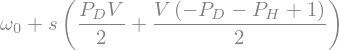

In [11]:
#fitness of doves
wd

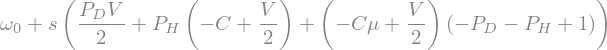

In [12]:
#fitness of reciprocators
wr

We can find the equations for nullclines - values at which two of the fitnesses are equal. Fixed points are given by the points at which all nullclines intersect.

In [13]:
alpha = wh-wd
beta = wd-wr

h_d_nullcline = solve([alpha],PH,PD)
d_r_nullcline = solve([beta],PH,PD)
h_r_nullcline = solve([alpha+beta],PH,PD)


fixed_points = solve([alpha,beta],PH,PD)

h_d_nullcline, d_r_nullcline, h_r_nullcline

In [14]:
def h_d_null_func(pd,v,c,mu):
    null_sol = lambdify([V,C,PD],h_d_nullcline[PH],'numpy')
    ph = null_sol(v,c,pd)
    pr = 1-pd-ph
    
    return (pd,pr,ph)

def d_r_null_func(pd,v,c,Mu):
    null_sol = lambdify([V,C,PD,mu],d_r_nullcline[PH],'numpy')
    ph = null_sol(v,c,pd,Mu)
    pr = 1-pd-ph
    
    return (pd,pr,ph)

def h_r_null_func(pd,v,c,Mu):
    null_sol = lambdify([V,C,PD,mu],h_r_nullcline[PH],'numpy')
    ph = null_sol(v,c,pd,Mu)
    pr = 1-pd-ph
    
    return (pd,pr,ph)

In [15]:
#Analytical solution for fixed points
fixed_points

We can find fixed points by plotting these nullclines on a simplex and looking at points of intersection: i.e plotting nullclines under the constraint that all are positive and that $P_H + P_D + P_R \leq 1$

In [16]:
def within_simplex(r): #Find out whether a given point lies within the S_1 simplex
    if r[0]+r[1]+r[2] <= 1 and r[0] >= 0 and r[1] >= 0 and r[2] >= 0:
        return True
    else:
        return False
    
#Convert the nullclines into Python functions
wd_func = lambdify([PD,PH,V,w0,s],wd)
wh_func = lambdify([PD,PH,V,C,w0,s],wh)
wr_func = lambdify([PD,PH,V,C,mu,w0,s],wr)

#Get the vector describing the trajectory at each point
#Trajectory is given by the replicator equation df/dt = (w-w_bar)f
def get_vector(pd,ph,v,c,mu,w0,s):
    
    #get the fitness values
    wd_val = wd_func(pd,ph,v,w0,s)
    wh_val = wh_func(pd,ph,v,c,w0,s)
    wr_val = wr_func(pd,ph,v,c,mu,w0,s)
    
    #Get relative fitness
    w_bar = pd*wd_val + ph*wh_val + (1-pd-ph)*wr_val
    wd_val -= w_bar
    wh_val -= w_bar
    wr_val -= w_bar
    
    #Project the 3D Cartesian coordinates onto a 2D simplex
    r_proj = project_point((pd,1-pd-ph,ph))
    dr_proj = project_point((pd*wd_val,(1-pd-ph)*wr_val,ph*wh_val))
    
    return r_proj,dr_proj

def get_color(pd,ph,v,c,mu,w0,s): #To indicate which strategy is best at that point
    
    wd = wd_func(pd,ph,v,w0,s)
    wh = wh_func(pd,ph,v,c,w0,s)
    wr = wr_func(pd,ph,v,c,mu,w0,s)
    
    if wd >= wh and wd >= wr:
        return 'red'
    if wh >= wd and wh >= wr:
        return 'green'
    if wr >= wh and wr >= wd:
        return 'blue'
    else:
        return 'black'   

In [17]:
def make_ternary_plot(V,C,mu,w0=0,s=1,plot_field=True,plot_nullclines=True,save=False,filename=''):
    
    figure, tax = ternary.figure(scale=1)

    fontsize = 16
    offset = 0.11
    
    #set background
    tax.set_background_color(color="#bbbbbb", alpha=0.7)
    
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    tax.gridlines(color="#aaaaaa", linestyle='-',linewidth=1, multiple=1)
    tax.gridlines(color="#aaaaaa", linestyle='-',linewidth=0.5, multiple=0.2,alpha=0.5)
    
    #Depict parameter values
    tax.set_title("V = "+ str(V) + "\nC = " + str(C) + "\n$\mu$ = " + str(mu) + '\nV/2C = ' + format(V/(2*C),'.2f'),position=(-0.05,1.5,-0.03),fontsize=18)

    #Label the axes and vertices
    tax.top_corner_label("Pure Reciprocator", fontsize=fontsize,position=(-0.1,1.2,-0.03),offset=0)
    tax.left_corner_label("Pure\nHawk", fontsize=fontsize,position=(-0.05,-0.01,1.1),offset=0)
    tax.right_corner_label("Pure\nDove", fontsize=fontsize,position=(1.05,0,-0.02),offset=0)
    tax.left_axis_label("$P_H$", fontsize=18, offset=0.16)
    tax.right_axis_label("$P_R$", fontsize=18, offset=0.16)
    tax.bottom_axis_label("$P_D$", fontsize=18, offset=0.16)
    
    if plot_nullclines:
        
        pd_list = np.arange(0,1.01,0.01)
        h_d_null = []
        h_r_null = []
        d_r_null = []
        for pd in pd_list:
        
            #Get the value of the H-D null
            tuple1 = h_d_null_func(pd,V,C,mu)
            if within_simplex(tuple1):
                h_d_null.append(tuple1)
        
            #Get the value of the H-R null
            tuple2 = h_r_null_func(pd,V,C,mu)
            if within_simplex(tuple2):
                h_r_null.append(tuple2)
        
            #Get the value of the D-R null
            tuple3 = d_r_null_func(pd,V,C,mu)
            if within_simplex(tuple3):
                d_r_null.append(tuple3)
    
        #Plot nullclines
        if len(h_d_null) > 0:
            tax.plot(h_d_null,linewidth=2.0,color='green',label='H-D nullcline')
        if len(h_r_null) > 0:
            tax.plot(h_r_null,linewidth=2.0,color='#0047ab',label='R-H nullcline')
        if len(d_r_null) > 0:
            tax.plot(d_r_null,linewidth=2.0,color='orange',label='D-R nullcline')
    
    #draw the vector field
    if plot_field:
        length = 0.02
        prop_list = np.arange(0,1.2,0.05)
        for pd in prop_list:
            for ph in prop_list:
                if within_simplex((pd,ph,1-pd-ph)):
                    r, dr = get_vector(pd,ph,V,C,mu,w0,s)
                    if np.hypot(dr[0],dr[1]) != 0:
                        dx,dy = length*dr/np.hypot(dr[0],dr[1])
                    else:
                        dx,dy = 0,0
                    color = get_color(pd,ph,V,C,mu,w0,s)
                    tax.get_axes().quiver(r[0],r[1],dx,dy,color=color,width=0.005,scale=0.1,scale_units='inches')
    
    tax.ticks(axis='lbr', fontsize=13, multiple=0.2, linewidth=0.5, tick_formats="%.1f",axes_colors={'l':'white','r':'white','b':'white'}, offset=0.02)    
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()
    tax.legend()
    
    if save:
        tax.savefig(str(filename+".png"))
    tax.show()

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/var/folders/b_/xqbznk296tb4z4dhdrlrd4rr0000gn/T/ipykernel_21433/3399975650.py:17: SyntaxWarning: invalid escape sequence '\m'
  tax.set_title("V = "+ str(V) + "\nC = " + str(C) + "\n$\mu$ = " + str(mu) + '\nV/2C = ' + format(V/(2*C),'.2f'),position=(-0.05,1.5,-0.03),fontsize=18)


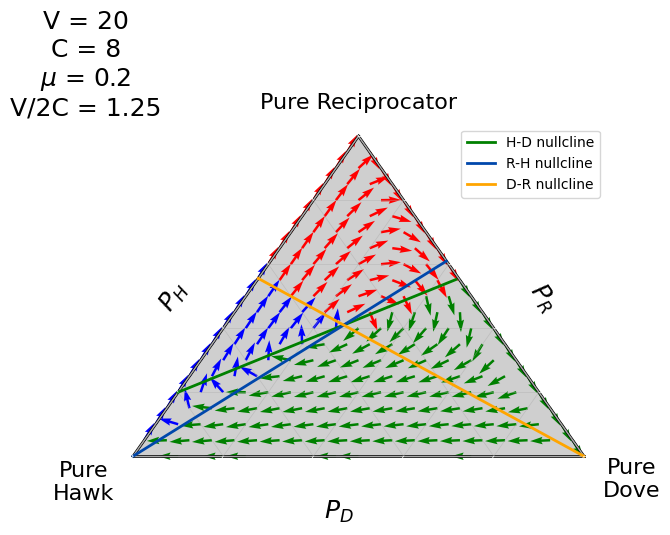

In [18]:
make_ternary_plot(20,8,0.2,save=False)